# Computer Class 3 - clustering and Bayesian learning

The examples and exercises in this computer class introduce the student to clustering techniques and Bayesian learning. This computer class can be used in conjunction with chapters 4 and 5 of the reader.

_Authors: Cees Diks and Bram Wouters, Faculty Economics and Business, University of Amsterdam (UvA)_ <br>
_Copyright (C): UvA (2023)_ <br>
_Credits: some of the examples and formulations are taken from Hastie et al. (2009)_


In [45]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing

# Part 1: K-means clustering for California housing market

In this section, we will use K-means clustering to segmet geographically the California housing market.

In the cell below, we import a dataset about the California housing market from scikit-learn. It contains information about 20640 properties. We will be mostly interested in the geographical information (the columns `Latitude` and `Longitude`) of the dataset.


In [46]:
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame
print(len(df))
df.head()

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**Example:** in the cell below, we put the longitude and latitude information of the DataFrame into a single 2-dimensional NumPy array. This is because we prefer to write the K-means clustering algorithm with NumPy.

We also plotted the geographical information as a scatter plot.


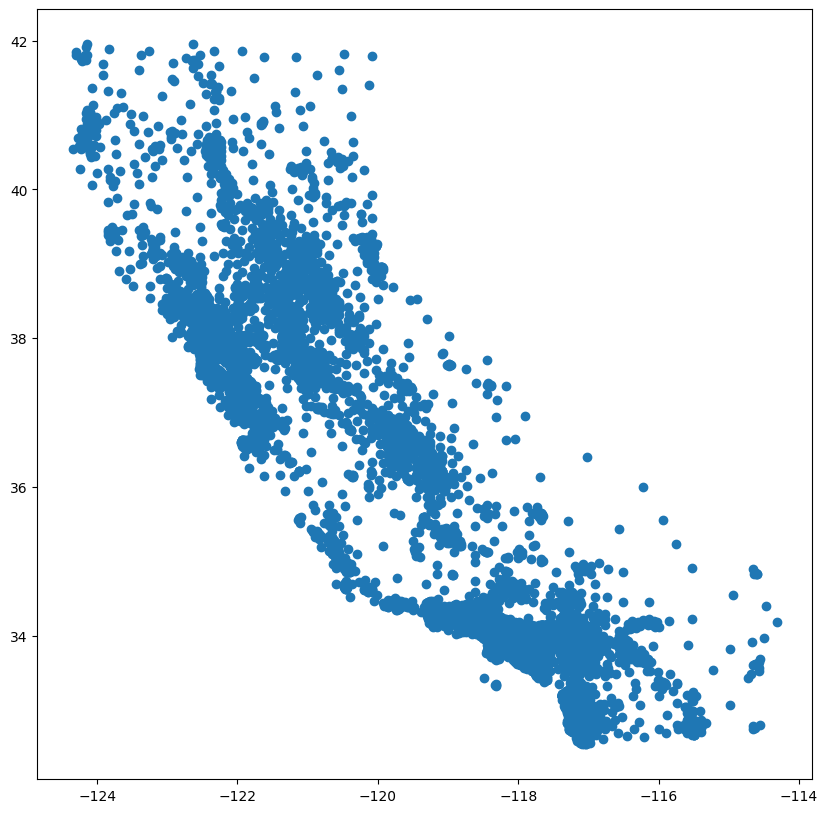

In [47]:
X = np.array(df[["Longitude", "Latitude"]])

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1]);

**Exercise 1:** write a function `K_means` that performs the K-means clustering algorithm, given as input the location data `X` and the number of clusters `K`. Use the squared Euclidian distance (in units of longitude and latitude) as the similarity metric. Abort the iterative algorithm if the average squared Euclidian distance with respect to the respective class means does not decrease more than 0.1%, as compared to the previous iteration.

The function `K_means` should (at least) return a 1-dimensional array of integers between $0$ and $K-1,$ representing the cluster to which each of the houses is assigned to.

Hint: this is not an easy algorithm. It may be useful to first define a number of other functions (subroutines) that perform simple tasks and finally combine these simple functions into the `K_means` function.


In [55]:
def K_means(
    X: np.ndarray, K: int, max_iterations: int = 1000, tol: float = 1e-4
) -> tuple[np.ndarray, np.ndarray]:
    # Random centroids
    centroids = X[np.random.choice(range(len(X)), K, replace=False)]

    for _ in range(max_iterations):
        # Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, None] - centroids, axis=2)
        point_assignments: np.ndarray = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array(
            [X[point_assignments == k].mean(axis=0) for k in range(K)]
        )

        # Check for convergence
        difference = new_centroids - centroids
        # difference /= centroids
        difference_per_centroid = np.mean(difference, axis=1)
        if np.all(difference_per_centroid < tol):
            break
        centroids = new_centroids

    return point_assignments, centroids  # type: ignore


Y, centroids = K_means(X, 8, max_iterations=int(1e100))


**Example:** if you have defined the final clustering of the K-means algorithm as a 1-dimensional array `Y` and you run the cell below, the clustering will be visualized.


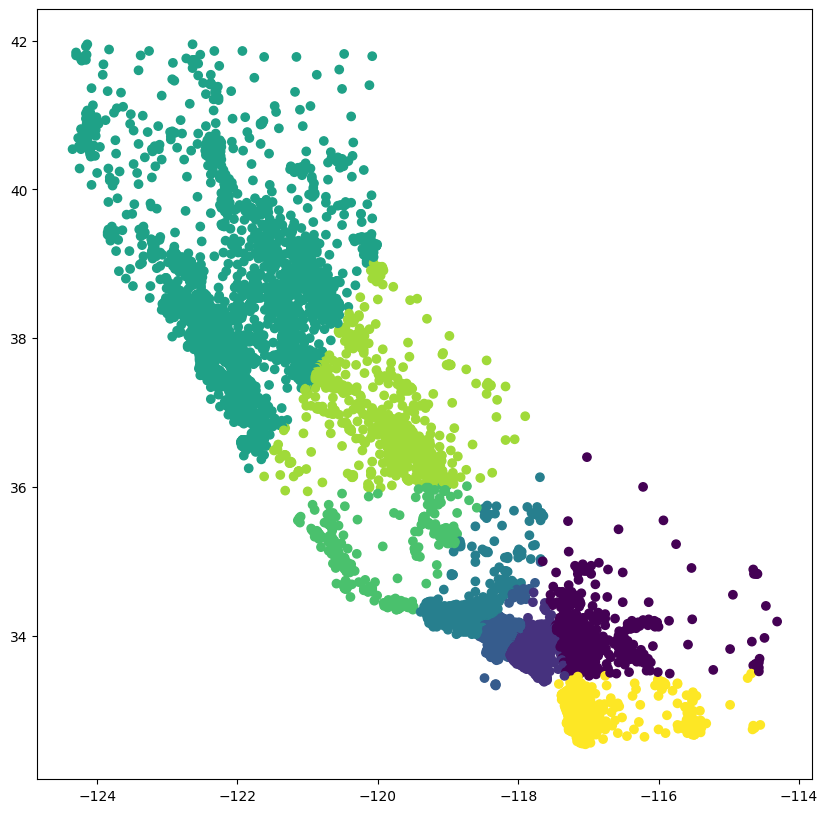

In [56]:
try:
    Y
except:
    K = 10
    Y = np.random.randint(K, size=X.shape[0])

df["clusters"] = Y
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df["Longitude"], df["Latitude"], c=df["clusters"]);

**Exercise 2:** define a function `K_means_scan` that runs the K-means algorithm several times (every time with a different initial random segmentation) and return the optimal segmentation. By optimal, we mean the segmentation with the smallest average squared Euclidian distance with respect to the respective class means.


In [60]:
def K_means_scan():
    Y_best = None
    best_result = 1e100
    for K in range(2, 15):
        Y, centroids = K_means(X, K)
        distance_to_centroid = np.sqrt((X - centroids[Y]) ** 2)
        result = np.mean(
            np.array([distance_to_centroid[Y == k].mean() for k in range(K)])
        )
        if result < best_result:
            best_result = result
            Y_best = Y
    return Y_best


Y_best = K_means_scan()


**Example:** if you have defined the optimal clustering of the K-means algorithm as a 1-dimensional array `Y_best` and you run the cell below, the optimal clustering will be visualized.


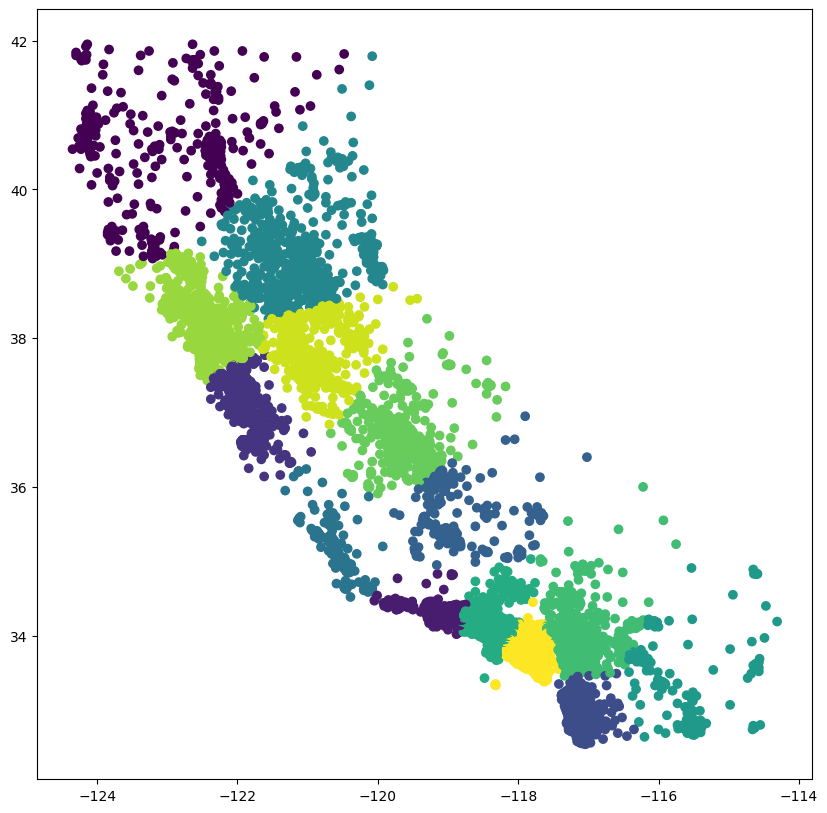

In [61]:
try:
    Y_best
except:
    K = 10
    Y_best = np.random.randint(K, size=X.shape[0])

df["clusters"] = Y_best
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df["Longitude"], df["Latitude"], c=df["clusters"]);

# Part 2: Bayesian parameter estimation

In this section, we consider a sample of size $n$ from the Laplace distribution (also called "double exponential" distribution), whose pdf is
$$ f(x; \theta, \eta) = \frac{1}{2\theta} \exp \left( - | x - \eta |/\theta \right), $$
where $\theta>0$ is a scale parameter and $\eta \in \mathbb{R}$ is a location parameter. We will assume that $\theta=1.0$ is a known parameter, while $\eta$ is unknown.

The function `generate_data` in the cell below can be used to generate samples drawn from the Laplace distribution.


In [62]:
def generate_data(n, eta, theta):
    """
    Generates a sample of size n drawn from the Laplace distribution with parameters eta (location)
    and theta (scale). Returns the sample as a 1-dimensional array.
    """

    return np.random.laplace(loc=eta, scale=theta, size=(n,))

**Exercise 3:** in the cell below, 3 functions are defined. The first function `posterior` computes, based on the data and a prior, the unnormalized posterior for the unknown parameter `eta`. The latter two functions use the function `posterior` to create a normalized posterior that can be applied to an array of input values.

Finish the code of the function `posterior`. Use the docstring for details about what the function should do. The latter two functions can remain untouched.


In [81]:
def laplace_pdf(data, eta, theta):
    return 1 / (2 * theta) * np.exp(-np.abs(data - eta) / theta)


def posterior(eta, data, theta=1.0, prior=None):
    """
    Returns the value (a float) of the unnormalized posterior for a given value of the parameter eta,
    based on a sample of observations called data.

    The prior input should be a function with one argument (the parameter eta). If prior is None,
    we use a constant prior of value 1.
    """
    if prior is None:
        def prior(x):
            return 1.0

    likelihood = np.prod(laplace_pdf(data, eta, theta))
    return likelihood * prior(eta)


def posterior_function(etas, data, theta=1.0, prior=None):
    """
    Computes the unnormalized posterior for an array of values for eta (etas).
    """

    return np.array(
        list(map(lambda x: posterior(x, data, theta=theta, prior=prior), etas))
    )


def posterior_function_normalized(
    etas, data, N=1000, left=None, right=None, eta_axis=None, theta=1.0, prior=None
):
    """
    Computes the normalized posterior for an array of values for eta (etas).
    """

    if left is None:
        left = np.mean(data) - 5 * theta / np.sqrt(n)
    if right is None:
        right = np.mean(data) + 5 * theta / np.sqrt(n)
    if eta_axis is None:
        eta_axis = np.linspace(left, right, N)

    norm = (
        np.sum(posterior_function(eta_axis, data, theta=theta, prior=prior))
        * (right - left)
        / N
    )

    return posterior_function(etas, data, theta=theta, prior=prior) / norm


**Example:** If you completed the previous exercise correctly, the cell below plots two normalized posteriors for `eta` based on `n` datapoints: one for a constant prior, and one for a standard normal prior.


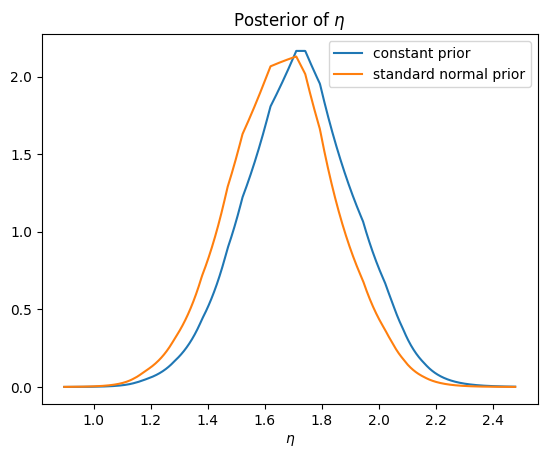

In [82]:
n = 40
eta = 2.2
theta = 1.0
data = generate_data(n, eta, theta)


def standard_normal_prior(eta):
    """
    Defines the standard normal Gaussian as a prior for the unknown parameter eta.
    """
    return np.exp(-(eta**2) / 2) / np.sqrt(2 * np.pi)


left = np.mean(data) - 5 * theta / np.sqrt(n)
right = np.mean(data) + 5 * theta / np.sqrt(n)

N = 1000
eta_axis = np.linspace(left, right, N)

try:
    fig, ax = plt.subplots()

    Lfunc = posterior_function_normalized(eta_axis, data)
    ax.plot(eta_axis, Lfunc, label="constant prior")

    Lfunc = posterior_function_normalized(eta_axis, data, prior=standard_normal_prior)
    ax.plot(eta_axis, Lfunc, label="standard normal prior")

    ax.set_title("Posterior of $\eta$")
    ax.set_xlabel("$\eta$")
    ax.legend()
except Exception as e:
    print(e)

**Exercise 4:** plot the normalized posterior for different values of the sample size $n$ (take $n=10,20,40,80,160,260,400$) in the sample graph. Make sure that you understand the trend visible in the plot.


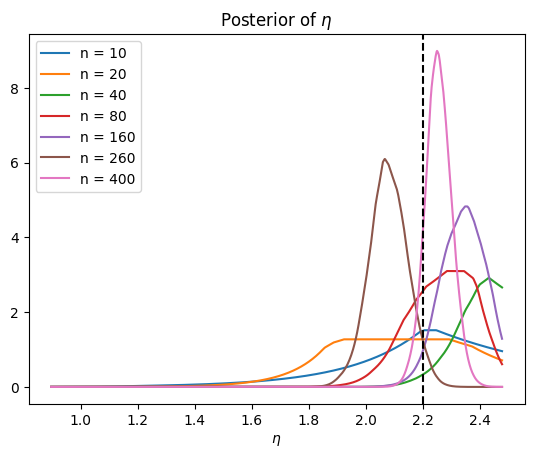

In [88]:
fig, ax = plt.subplots()
for n in [10, 20, 40, 80, 160, 260, 400]:
    data = generate_data(n, eta, theta)

    Lfunc = posterior_function_normalized(eta_axis, data)
    ax.plot(eta_axis, Lfunc, label=f"n = {n}")

ax.set_title("Posterior of $\eta$")
ax.set_xlabel("$\eta$")
ax.legend() 
ax.axvline(eta, color="black", linestyle="--")

**Exercise 5:** write a function `Bayes_estimator_eta` that returns a Bayes estimate of the unknown parameter $\eta$, given some data `data`. Make a distinction between two losses: for a `squared` loss (the default) the estimate is the conditional mean of $\eta$ (in other words: the posterior mean of $\eta$), while for an `absolute` loss the estimate is the median of the posterior distribution. The function should work correctly for both choices of Bayes estimator.


In [126]:
def Bayes_estimator_eta(data, loss="squared", N=1000, theta=1.0):
    """
    Returns the Bayes estimate for the unknown parameter eta. In the case of a squared loss, this is the
    posterior mean of eta. In the case of an absolute loss, this is the median of the posterior.
    """
    LFunc = posterior_function_normalized(eta_axis, data, N=N, theta=theta)
    if loss == "squared":
        # Posterior mean
        # Integrate eta * LFunc(eta) over eta
        return np.trapezoid(eta_axis * LFunc, eta_axis)
    elif loss == "absolute":
        return eta_axis[np.argmax(LFunc.cumsum() > 0.5)]

**Exercise 6:** print for different values of the sample size $n$ (take $n=10,20,40,80,160,260,400$) three different estimates of the unknown parameter $\eta$:

- the sample mean.
- the Bayes estimator using a squared loss.
- the Bayes estimator using an absolute loss.
  Observe that all estimators perform better for larger sample sizes.


In [128]:
for n in [10, 20, 40, 80, 160, 260, 400]:
    data = generate_data(n, eta, theta)

    sample_mean = np.mean(data)
    bayes_squared = Bayes_estimator_eta(data, loss="squared")
    bayes_absolute = Bayes_estimator_eta(data, loss="absolute")
    # print nice output
    print(
    f"+{'-'*44}+"
    f"\n| {'n =':>5} {n:^4} | {'Sample Mean':>20} = {sample_mean:>6.2f} |"
    f"\n| {'':>10} | {'Bayes Squared Loss':>20} = {bayes_squared:>6.2f} |"
    f"\n| {'':>10} | {'Bayes Absolute Loss':>20} = {bayes_absolute:>6.2f} |"
)
print(f"+{'-'*44}+")


+--------------------------------------------+
|   n =  10  |          Sample Mean =   2.94 |
|            |   Bayes Squared Loss =   0.49 |
|            |  Bayes Absolute Loss =   1.66 |
+--------------------------------------------+
|   n =  20  |          Sample Mean =   2.03 |
|            |   Bayes Squared Loss =   1.87 |
|            |  Bayes Absolute Loss =   1.07 |
+--------------------------------------------+
|   n =  40  |          Sample Mean =   2.52 |
|            |   Bayes Squared Loss =   1.19 |
|            |  Bayes Absolute Loss =   1.96 |
+--------------------------------------------+
|   n =  80  |          Sample Mean =   1.98 |
|            |   Bayes Squared Loss =   2.11 |
|            |  Bayes Absolute Loss =   1.64 |
+--------------------------------------------+
|   n = 160  |          Sample Mean =   2.27 |
|            |   Bayes Squared Loss =   2.21 |
|            |  Bayes Absolute Loss =   1.95 |
+--------------------------------------------+
|   n = 260  